# IBM Applied Data Science Specialization
 ### By Mike L
 <i>This notebook is used for my Capstone Project which concludes the 9 course specialization in Data Science</i>

# <u>PROBLEM
### The perfect night out:

People (both tourists and residents alike) can become overwhelmed when planning a night out in a large city such as New York due to the seemingly endless amount of choices. This situation can actually become stressful and lead to less than optimal experiences. 
The notebook will focus on building a classification model that analyzes nightlife data to recommend optimal bars according to the type of desired experience: <b><ul><li>lively venues (<u>Code Label: L</u>) <li>relaxed venues("chill" with<u> Code Label:C</u>) <li>romantic venues(<u>Code Label:R</u>). 

# <u>Data (From Foursquare API)
### Location: Williamsburg Neighborhood, Brooklyn, NY

<ul>
    <li> Data is extracted by calling the api for 50 nightlife venues in the neighborhood and then details for each venue.
    <ul><li><b> target attributes for the model are filtered and extracted from the details data set which are a combination of<ul><li> categories<li> venue types <li> price
        
        

    
# <u>Methodology</u> 
This problem calls for a heuristic approach because results and target attributes can differ.  <ul><li><b>The model: multiclass Support Vector Machine model </b> was employed to discover labels of nightlife venues.
    <li><b>The data: 50 venues and split with 35 venues to train and 15 venues to test.</b> 
    
# <u>Results  
After optimizing the model to the best of my abilities, the model classified  <ul><li> Lively venues with an F1 score of 0.82 <li>Relaxed(Chill) venues  with an F1 score of 0.67 <li> Romantic venues with an F1 score of 0.40 while being confused with Lively venues.
    


              precision    recall  f1-score   support

           C       1.00      0.50      0.67         2
           L       0.69      1.00      0.82         9
           R       1.00      0.25      0.40         4

   micro avg       0.73      0.73      0.73        15
   macro avg       0.90      0.58      0.63        15
weighted avg       0.82      0.73      0.69        15

Confusion matrix, without normalization
[[9 0 0]
 [1 1 0]
 [3 0 1]]


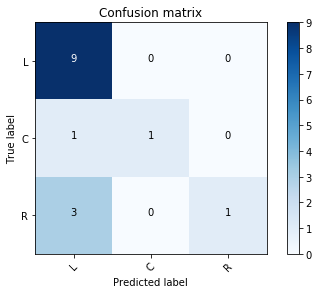

In [52]:

cnf_matrix = confusion_matrix(y_test, yhat, labels=['L','C','R'])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['L','C','R'],normalize= False,  title='Confusion matrix')

# <u>Discussion  
There were multiple issues during this project:
    <ol><li> Foursquare API <ol><li>detail responses were difficult to work with due to heavily layered JSON outputs
        <li> Venue detail output unformity is lacking and missing in some cases which creates a data wrangling challenge.</ol>
        <li> Due to a heavy imbalance in class labels during training of the model, confusion of labels tended to label venue types as Lively (majority of venues were labeled as lively in training.
            <ol><li> future approaches will need to take a large set of each classification and train on them separately in a binary approach (ex: 30 Lively venues labeled Lively or not, 30 Chill venues labeled Chill or not etc...)</ol>
            <li> Another future approach would be to text mine user responses/tips/labels and establish categories from uniformly assigned categories based on user responses.
# <u>Conclusion  
In conclusion, this notebook is a solid attempt to classify nightlife because from the results as it offers a legitimate alternative to recommender systems where user data may be sparse in the beginning. There are many approaches that can be taken to vastly improve accuracy.

# Notebook Start--> 

import relevant modules

In [2]:
import pandas as pd
import numpy as np
import urllib.request
from bs4 import BeautifulSoup
import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn import svm
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')


Solving environment: \ 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/linux-64::anaconda==5.3.1=py37_0
  - defaults/linux-64::astropy==3.0.4=py37h14c3975_0
  - defaults/linux-64::bkcharts==0.2=py37_0
  - defaults/linux-64::blaze==0.11.3=py37_0
  - defaults/linux-64::bokeh==0.13.0=py37_0
  - defaults/linux-64::bottleneck==1.2.1=py37h035aef0_1
  - defaults/linux-64::dask==0.19.1=py37_0
  - defaults/linux-64::datashape==0.5.4=py37_1
  - defaults/linux-64::mkl-service==1.1.2=py37h90e4bf4_5
  - defaults/linux-64::numba==0.39.0=py37h04863e7_0
  - defaults/linux-64::numexpr==2.6.8=py37hd89afb7_0
  - defaults/linux-64::odo==0.5.1=py37_0
  - defaults/linux-64::pytables==3.4.4=py37ha205bf6_0
  - defaults/linux-64::pytest-arraydiff==0.2=py37h39e3cac_0
  - defaults/linux-64::pytest-astropy==0.4.0=py37_0
  - defaults/linux-64::pytest-doctestplus==0.1.3=py37_0
  - defaults/linux-64::pywavelets==1.0.0=py37h

In [3]:
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker

#### Foursquare credentials

In [4]:
# @hidden_cell
CLIENT_ID = 'KRVSESWEJ3425PB5ZIF34SXP5PEDKSHY3BEYJDX5BK2EQAYP' # your Foursquare ID
CLIENT_SECRET = 'NA0QNVTDNVCU0RPJC1MXPCKBRWIQJORLA2D1FRB5FBUOZZIJ' # your Foursquare Secret
VERSION = '20180323'


#### define an instance of the geocoder

In [5]:
address = '194 Montrose Ave, Brooklyn, NY'
geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

#### Query params

In [6]:
LIMIT = 500
categoryId = '4d4b7105d754a06376d81259'
radius = 2000
print(latitude, longitude)

40.7072963 -73.9417598021537


#### Define the corresponding URL & Send the GET Request and examine the results

In [7]:
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}&limit={}'.format(
    CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, categoryId, radius, LIMIT)

results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5cbdeed26a60715ae18dd975'},
 'response': {'venues': [{'id': '56f494c5498eabd4fd4b017f',
    'name': 'The Rosemont',
    'contact': {},
    'location': {'address': '63 Montrose Ave',
     'crossStreet': 'Lorimer',
     'lat': 40.70694235571774,
     'lng': -73.94737999415942,
     'labeledLatLngs': [{'label': 'display',
       'lat': 40.70694235571774,
       'lng': -73.94737999415942}],
     'distance': 475,
     'cc': 'US',
     'city': 'Brooklyn',
     'state': 'NY',
     'country': 'United States',
     'formattedAddress': ['63 Montrose Ave (Lorimer)',
      'Brooklyn, NY',
      'United States']},
    'categories': [{'id': '4bf58dd8d48988d1d8941735',
      'name': 'Gay Bar',
      'pluralName': 'Gay Bars',
      'shortName': 'Gay Bar',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/gaybar_',
       'suffix': '.png'},
      'primary': True}],
    'verified': False,
    'stats': {'tipCount': 0,
     'usersCount': 0,
   

#### Get relevant part of JSON and transform it into a *pandas* dataframe

In [8]:
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)
dataframe.head()

,beenHere.count,beenHere.lastCheckinExpiredAt,beenHere.marked,beenHere.unconfirmedCount,categories,delivery.id,delivery.provider.icon.name,delivery.provider.icon.prefix,delivery.provider.icon.sizes,delivery.provider.name,...,location.state,name,referralId,stats.checkinsCount,stats.tipCount,stats.usersCount,stats.visitsCount,venueChains,venuePage.id,verified
0,0,0,False,0,"[{'id': '4bf58dd8d48988d1d8941735', 'name': 'G...",NaN,NaN,NaN,NaN,NaN,...,NY,The Rosemont,v-1555951314,0,0,0,0,[],NaN,False
1,0,0,False,0,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",NaN,NaN,NaN,NaN,NaN,...,NY,Gertie,v-1555951314,0,0,0,0,[],NaN,False
2,0,0,False,0,"[{'id': '4bf58dd8d48988d118941735', 'name': 'D...",NaN,NaN,NaN,NaN,NaN,...,NY,The Levee,v-1555951314,0,0,0,0,[],78890005,True
3,0,0,False,0,"[{'id': '4bf58dd8d48988d11f941735', 'name': 'N...",NaN,NaN,NaN,NaN,NaN,...,NY,House of Yes,v-1555951314,0,0,0,0,[],NaN,False
4,0,0,False,0,"[{'id': '4bf58dd8d48988d118941735', 'name': 'D...",NaN,NaN,NaN,NaN,NaN,...,NY,Skinny Dennis,v-1555951314,0,0,0,0,[],NaN,False


# Filter Json

In [9]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]
dataframe_filtered.drop(columns=['cc','city', 'country','crossStreet','distance','formattedAddress','labeledLatLngs','neighborhood','postalCode','state'], inplace=True)


# Function to query api, parse json and create list from resulting json


In [10]:
def getdetails(venue_ids):
    
    venues_list=[]
    
    for v_id in venue_ids: 
        url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(
            v_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
        
        # make the GET request
        results = requests.get(url).json()["response"]
        venue = results['venue']
        
        categories = venue.get('categories', [{'name':''}, {'name':''}])#strings
        price = venue.get('price', {'tier': 0}) #ints
        likes = venue.get('likes', {'count': 0})
        hours = venue.get('hours',{'timeframes':[{'open':[{'renderedTime':''}]},{'open':[{'renderedTime':''}]}]})
        attributes=venue.get('attributes',{'groups':[{'summary':''},{'summary':''},{'summary':''},{'summary':''}]})
        
        
        # return only relevant information for each venue
        venues_list.append([
            venue.get('name',''), 
            categories[0]['name'] if len(categories) > 0 else '', 
            categories[1]['name'] if len(categories) > 1 else categories[0]['name'], 
            price['tier'] if 'tier' in price else 0,
            likes['count'] if 'count' in likes else 0, 
            venue['rating'] if 'rating' in venue else 0,
            hours['timeframes'][0]['open'][0]['renderedTime'] if len(hours['timeframes']) > 0 else '',
            hours['timeframes'][1]['open'][0]['renderedTime'] if len(hours['timeframes']) > 1 else hours['timeframes'][0]['open'][0]['renderedTime'],
            attributes['groups'][0] if len(attributes['groups']) > 0 else '',
            attributes['groups'][1] if len(attributes['groups']) > 1 else '',
            attributes['groups'][2] if len(attributes['groups']) > 2 else '',
            attributes['groups'][3] if len(attributes['groups']) > 3 else ''])
    
            
        
    return(venues_list)


# Query details using id column from previous dataframe as parameter

In [11]:
detail_data=getdetails(venue_ids=dataframe_filtered['id'])


Create Pandas Dataframe with appropriate columns

In [12]:
ven_details_df=pd.DataFrame(data=detail_data)
ven_details_df.columns=('venue_name',
                        'category_1',
                        'category_2',
                        'price',
                        'likes',
                        'rating',
                        'weekdayhours',
                        'weekendhours',
                        'attribute1',
                        'attribute2',
                        'attribute3',
                        'attribute4')
ven_details_df.head()


,venue_name,category_1,category_2,price,likes,rating,weekdayhours,weekendhours,attribute1,attribute2,attribute3,attribute4
0,The Rosemont,Gay Bar,Lounge,2,106,8.6,5:00 PM–4:00 AM,3:00 PM–4:00 AM,"{'type': 'price', 'name': 'Price', 'summary': ...","{'type': 'payments', 'name': 'Credit Cards', '...","{'type': 'outdoorSeating', 'name': 'Outdoor Se...","{'type': 'music', 'name': 'Music', 'summary': ..."
1,Gertie,Restaurant,Café,2,26,8.6,8:00 AM–Midnight,8:00 AM–Midnight,"{'type': 'price', 'name': 'Price', 'summary': ...","{'type': 'serves', 'name': 'Menus', 'summary':...",,
2,The Levee,Dive Bar,Bar,1,477,8.3,Noon–4:00 AM,Noon–4:00 AM,"{'type': 'price', 'name': 'Price', 'summary': ...","{'type': 'payments', 'name': 'Credit Cards', '...","{'type': 'outdoorSeating', 'name': 'Outdoor Se...","{'type': 'music', 'name': 'Music', 'summary': ..."
3,House of Yes,Nightclub,Performing Arts Venue,3,565,9.4,,,"{'type': 'price', 'name': 'Price', 'summary': ...","{'type': 'reservations', 'name': 'Reservations...","{'type': 'payments', 'name': 'Credit Cards', '...","{'type': 'outdoorSeating', 'name': 'Outdoor Se..."
4,Skinny Dennis,Dive Bar,Bar,1,670,8.7,Noon–4:00 AM,Noon–4:00 AM,"{'type': 'price', 'name': 'Price', 'summary': ...","{'type': 'payments', 'name': 'Credit Cards', '...","{'type': 'outdoorSeating', 'name': 'Outdoor Se...","{'type': 'music', 'name': 'Music', 'summary': ..."


Clean Details DataFrame

In [13]:
# unload attribute dictionary and apply summary of attributes to the dataframe attribute columns

vd1= ven_details_df['attribute1'].apply(pd.Series)
vd1=vd1['summary']
vd2= ven_details_df['attribute2'].apply(pd.Series)
vd2=vd2['summary']
vd3= ven_details_df['attribute3'].apply(pd.Series)
vd3=vd3['summary']
vd4= ven_details_df['attribute4'].apply(pd.Series)
vd4=vd4['summary']

ven_details_df['attribute1']=vd1
ven_details_df['attribute2']=vd2
ven_details_df['attribute3']=vd3
ven_details_df['attribute4']=vd4

# drop price column... API always returns price as first attrib.
ven_details_df=ven_details_df.drop(['attribute1'], axis=1)

# leave NaN space blank... left over from unloading the attribute dictionary
ven_details_df=ven_details_df.fillna('') 

# delete credit card attributes
ven_details_df['attribute2']=ven_details_df['attribute2'].replace('Credit Cards','', regex=True)
ven_details_df['attribute3']=ven_details_df['attribute3'].replace('Credit Cards','', regex=True)

#clean up time formats
ven_details_df['weekdayhours']=ven_details_df['weekdayhours'].replace('Midnight','12:00 AM', regex=True)
ven_details_df['weekendhours']=ven_details_df['weekendhours'].replace('Midnight','12:00 AM', regex=True)
ven_details_df['weekdayhours']=ven_details_df['weekdayhours'].replace('Noon','12:00 PM', regex=True)
ven_details_df['weekendhours']=ven_details_df['weekendhours'].replace('Noon','12:00 PM', regex=True)
ven_details_df.head()

,venue_name,category_1,category_2,price,likes,rating,weekdayhours,weekendhours,attribute2,attribute3,attribute4
0,The Rosemont,Gay Bar,Lounge,2,106,8.6,5:00 PM–4:00 AM,3:00 PM–4:00 AM,,Outdoor Seating,Live Music
1,Gertie,Restaurant,Café,2,26,8.6,8:00 AM–12:00 AM,8:00 AM–12:00 AM,"Dinner, Lunch & more",,
2,The Levee,Dive Bar,Bar,1,477,8.3,12:00 PM–4:00 AM,12:00 PM–4:00 AM,,Outdoor Seating,Jukebox
3,House of Yes,Nightclub,Performing Arts Venue,3,565,9.4,,,Reservations,,Outdoor Seating
4,Skinny Dennis,Dive Bar,Bar,1,670,8.7,12:00 PM–4:00 AM,12:00 PM–4:00 AM,,Outdoor Seating,Live Music


In [14]:
ven_details_df.head()

,venue_name,category_1,category_2,price,likes,rating,weekdayhours,weekendhours,attribute2,attribute3,attribute4
0,The Rosemont,Gay Bar,Lounge,2,106,8.6,5:00 PM–4:00 AM,3:00 PM–4:00 AM,,Outdoor Seating,Live Music
1,Gertie,Restaurant,Café,2,26,8.6,8:00 AM–12:00 AM,8:00 AM–12:00 AM,"Dinner, Lunch & more",,
2,The Levee,Dive Bar,Bar,1,477,8.3,12:00 PM–4:00 AM,12:00 PM–4:00 AM,,Outdoor Seating,Jukebox
3,House of Yes,Nightclub,Performing Arts Venue,3,565,9.4,,,Reservations,,Outdoor Seating
4,Skinny Dennis,Dive Bar,Bar,1,670,8.7,12:00 PM–4:00 AM,12:00 PM–4:00 AM,,Outdoor Seating,Live Music


In [15]:
weekdaysplithours = ven_details_df[["weekdayhours"]]
weekdaysplithours= weekdaysplithours["weekdayhours"].str.split('–', 1, expand=True)
ven_details_df['weekdayclose']=weekdaysplithours[1]
ven_details_df['weekdayclose']
weekendsplithours = ven_details_df[["weekendhours"]]
weekendsplithours= weekendsplithours["weekendhours"].str.split('–', 1, expand=True)
ven_details_df['weekendclose']=weekendsplithours[1]
wd_hourclass = ven_details_df[["weekdayclose"]]
wd_hourclass= wd_hourclass["weekdayclose"].str.split(' ', 1, expand=True)
wd_hourclass= wd_hourclass.replace('AM','lateNight', regex=True)
wd_hourclass= wd_hourclass.replace('PM','evening', regex=True)
ven_details_df['weekdayclose_cat']=wd_hourclass[1]
wd_hourclass1 = ven_details_df[["weekendclose"]]
wd_hourclass1= wd_hourclass1["weekendclose"].str.split(' ', 1, expand=True)
wd_hourclass1= wd_hourclass1.replace('AM','lateNight', regex=True)
wd_hourclass1= wd_hourclass1.replace('PM','evening', regex=True)
ven_details_df['weekendclose_cat']=wd_hourclass1[1]

In [16]:
ven_details_df.drop(['weekdayhours','weekendhours','weekdayclose','weekendclose'],axis=1,inplace=True)

In [17]:
ven_details_df.head()

,venue_name,category_1,category_2,price,likes,rating,attribute2,attribute3,attribute4,weekdayclose_cat,weekendclose_cat
0,The Rosemont,Gay Bar,Lounge,2,106,8.6,,Outdoor Seating,Live Music,lateNight,lateNight
1,Gertie,Restaurant,Café,2,26,8.6,"Dinner, Lunch & more",,,lateNight,lateNight
2,The Levee,Dive Bar,Bar,1,477,8.3,,Outdoor Seating,Jukebox,lateNight,lateNight
3,House of Yes,Nightclub,Performing Arts Venue,3,565,9.4,Reservations,,Outdoor Seating,None,None
4,Skinny Dennis,Dive Bar,Bar,1,670,8.7,,Outdoor Seating,Live Music,lateNight,lateNight


Clean and unify category and times 

In [18]:
vcat1 = ven_details_df[["category_1"]]
vcat1= vcat1["category_1"].str.split(' ', 1, expand=True)
vcat1[1]=vcat1[1].fillna(vcat1[0])
vcat2=vcat1[[1]]
vcat2= vcat2[1].str.split(' ', 3, expand=True)
vcat2[3]=vcat2[3].fillna(vcat2[0])
ven_details_df['venue_type']=vcat2[3]
ven_details_df['weekdayclose_cat']=ven_details_df['weekdayclose_cat'].fillna('lateNight')
ven_details_df['weekendclose_cat']=ven_details_df['weekendclose_cat'].fillna('lateNight')
ven_details_df.head()

,venue_name,category_1,category_2,price,likes,rating,attribute2,attribute3,attribute4,weekdayclose_cat,weekendclose_cat,venue_type
0,The Rosemont,Gay Bar,Lounge,2,106,8.6,,Outdoor Seating,Live Music,lateNight,lateNight,Bar
1,Gertie,Restaurant,Café,2,26,8.6,"Dinner, Lunch & more",,,lateNight,lateNight,Restaurant
2,The Levee,Dive Bar,Bar,1,477,8.3,,Outdoor Seating,Jukebox,lateNight,lateNight,Bar
3,House of Yes,Nightclub,Performing Arts Venue,3,565,9.4,Reservations,,Outdoor Seating,lateNight,lateNight,Nightclub
4,Skinny Dennis,Dive Bar,Bar,1,670,8.7,,Outdoor Seating,Live Music,lateNight,lateNight,Bar


## Save to csv file and LABEL "Outing Types" manually for training and testing
Labels: <ul><li>L = Lively <li>C = Chill (or relaxed) <li>R = Romantic

In [19]:
# save to csv and edit labels reopen with new labels for Train/Test
# ven_details_df.to_csv('venue_details.csv')


In [27]:
Labeled_Ven_OutingTypes_df=pd.read_csv('venue_details.csv')

In [28]:
Labeled_Ven_OutingTypes_df=Labeled_Ven_OutingTypes_df.fillna('')
Labeled_Ven_OutingTypes_df.head()

,Unnamed: 0,venue_name,category_1,category_2,price,likes,rating,attribute2,attribute3,attribute4,weekdayclose_cat,weekendclose_cat,venue_type,OutingType
0,0,The Rosemont,Gay Bar,Lounge,2,106,8.6,,Outdoor Seating,Live Music,lateNight,lateNight,Bar,L
1,1,Gertie,Restaurant,Café,2,26,8.6,"Dinner, Lunch & more",,,lateNight,lateNight,Restaurant,C
2,2,The Levee,Dive Bar,Bar,1,477,8.3,,Outdoor Seating,Jukebox,lateNight,lateNight,Bar,L
3,3,House of Yes,Nightclub,Performing Arts Venue,3,565,9.4,Reservations,,Outdoor Seating,lateNight,lateNight,Nightclub,L
4,4,Skinny Dennis,Dive Bar,Bar,1,670,8.7,,Outdoor Seating,Live Music,lateNight,lateNight,Bar,L


# Create target feature DateFrame

In [29]:
Feature = Labeled_Ven_OutingTypes_df[['category_2','price','attribute2','attribute3','attribute4','venue_type']]
Feature.head()

,category_2,price,attribute2,attribute3,attribute4,venue_type
0,Lounge,2,,Outdoor Seating,Live Music,Bar
1,Café,2,"Dinner, Lunch & more",,,Restaurant
2,Bar,1,,Outdoor Seating,Jukebox,Bar
3,Performing Arts Venue,3,Reservations,,Outdoor Seating,Nightclub
4,Bar,1,,Outdoor Seating,Live Music,Bar


# One hot encode feature Data Frame for preprocessing

In [33]:

Feature = pd.concat([Feature,pd.get_dummies(ven_details_df['category_2'])], axis=1)
Feature = pd.concat([Feature,pd.get_dummies(ven_details_df['attribute2'])], axis=1)
Feature = pd.concat([Feature,pd.get_dummies(ven_details_df['attribute3'])], axis=1)
Feature = pd.concat([Feature,pd.get_dummies(ven_details_df['attribute4'])], axis=1)
Feature = pd.concat([Feature,pd.get_dummies(ven_details_df['price'])], axis=1)
Feature = pd.concat([Feature,pd.get_dummies(ven_details_df['venue_type'])], axis=1)
Feature.head()

,Arcade,Bar,Beer Garden,Brewery,Café,Cocktail Bar,Coffee Shop,Concert Hall,Fried Chicken Joint,Gastropub,...,Bar,Brewery,Garden,Gastropub,Nightclub,Place,Pub,Restaurant,Space,Venue
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [ ]:
#drop first 6 columns as they now are redundant 
Feature.drop(['category_2','price','attribute2','attribute3','attribute4','venue_type'],axis=1, inplace=True)


In [25]:
Feature.head()

,Arcade,Bar,Beer Garden,Brewery,Café,Cocktail Bar,Coffee Shop,Concert Hall,Fried Chicken Joint,Gastropub,...,Bar,Brewery,Garden,Gastropub,Nightclub,Place,Pub,Restaurant,Space,Venue
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


## Build Model
<ol><li>assign variables
<li>preprocess/scale
    <li>split Train/test set
        <li> Train model
            <li> Test model

In [35]:
X = Feature.loc[0:50]
y = Labeled_Ven_OutingTypes_df['OutingType'].loc[0:50].values
z = Labeled_Ven_OutingTypes_df['venue_name'].loc[0:50].values

In [36]:
from sklearn import preprocessing
X= preprocessing.StandardScaler().fit(X).transform(X)
X

/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  


array([[-0.14285714, -0.68599434, -0.29488391, ..., -0.43643578,
        -0.14285714, -0.25264558],
       [-0.14285714, -0.68599434, -0.29488391, ...,  2.29128785,
        -0.14285714, -0.25264558],
       [-0.14285714,  1.45773797, -0.29488391, ..., -0.43643578,
        -0.14285714, -0.25264558],
       ...,
       [-0.14285714, -0.68599434, -0.29488391, ..., -0.43643578,
        -0.14285714, -0.25264558],
       [-0.14285714,  1.45773797, -0.29488391, ...,  2.29128785,
        -0.14285714, -0.25264558],
       [-0.14285714, -0.68599434, -0.29488391, ...,  2.29128785,
        -0.14285714, -0.25264558]])

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, z_train, z_test = train_test_split( X, y,z, test_size=0.3, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (35, 57) (35,)
Test set: (15, 57) (15,)


In [38]:
from sklearn import svm
SVM = svm.SVC(kernel='rbf',decision_function_shape='ovo', gamma='scale', class_weight='balanced')
SVM.fit(X_train, y_train)


SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [39]:
yhat = SVM.predict(X_test)
yhat

array(['L', 'R', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'C', 'L',
       'L', 'L'], dtype=object)

# Plot classification report to view accuracy/scores

In [40]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

           C       1.00      0.50      0.67         2
           L       0.69      1.00      0.82         9
           R       1.00      0.25      0.40         4

   micro avg       0.73      0.73      0.73        15
   macro avg       0.90      0.58      0.63        15
weighted avg       0.82      0.73      0.69        15

Confusion matrix, without normalization
[[9 0 0]
 [1 1 0]
 [3 0 1]]


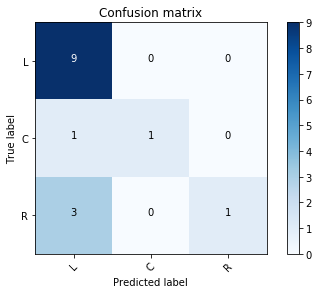

In [41]:
cnf_matrix = confusion_matrix(y_test, yhat, labels=['L','C','R'])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['L','C','R'],normalize= False,  title='Confusion matrix')

# Create and clean dataframes to view actual versus predicted results on a map

In [42]:
Labels=Labeled_Ven_OutingTypes_df[['venue_name','OutingType']]
brook_nightlife=dataframe_filtered[['lat','lng']]
brook_nightlife['name']=Labels[['venue_name']]
brook_nightlife['Label']=Labels[['OutingType']]


/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [43]:
brook_nightlife[['Label-num']]=brook_nightlife[['Label']]
brook_nightlife[['Label-num']]=brook_nightlife[['Label-num']].replace('L',1)
brook_nightlife[['Label-num']]=brook_nightlife[['Label-num']].replace('C',2)
brook_nightlife[['Label-num']]=brook_nightlife[['Label-num']].replace('R',3)
brook_nightlife.head()

/home/jupyterlab/conda/lib/python3.6/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


,lat,lng,name,Label,Label-num
0,40.706942,-73.947380,The Rosemont,L,1
1,40.712368,-73.955592,Gertie,C,2
2,40.716468,-73.961475,The Levee,L,1
3,40.706777,-73.923704,House of Yes,L,1
4,40.715978,-73.961985,Skinny Dennis,L,1


In [44]:
true_labels_df=pd.DataFrame({'name':z_test,'True_category_labels':y_test})
true_labels_df

,name,True_category_labels
0,Music Hall of Williamsburg,L
1,Zona Rosa,R
2,Macri Park,L
3,Skinny Dennis,L
4,Heavy Woods,L
5,Metropolitan,L
6,Radegast Hall & Biergarten,L
7,Hotel Delmano,R
8,The Four Horsemen,R
9,Sweet Chick,C


In [45]:
predicted_labels_df=pd.DataFrame({'name':z_test,'Predicted_category_labels':yhat})

In [46]:
predicted_labels_df=predicted_labels_df.merge(brook_nightlife, on='name', how='left')
predicted_labels_df['pred_num']=predicted_labels_df['Predicted_category_labels']
predicted_labels_df[['pred_num']]=predicted_labels_df[['pred_num']].replace('L',1)
predicted_labels_df[['pred_num']]=predicted_labels_df[['pred_num']].replace('C',2)
predicted_labels_df[['pred_num']]=predicted_labels_df[['pred_num']].replace('R',3)

In [47]:
predicted_labels_df.head()

,name,Predicted_category_labels,lat,lng,Label,Label-num,pred_num
0,Music Hall of Williamsburg,L,40.719244,-73.961679,L,1,1
1,Zona Rosa,R,40.714036,-73.949648,R,3,3
2,Macri Park,L,40.714263,-73.951681,L,1,1
3,Skinny Dennis,L,40.715978,-73.961985,L,1,1
4,Heavy Woods,L,40.705645,-73.921629,L,1,1


In [48]:
true_labels_df=true_labels_df.merge(brook_nightlife, on='name', how='left')

In [49]:
true_labels_df.head()

,name,True_category_labels,lat,lng,Label,Label-num
0,Music Hall of Williamsburg,L,40.719244,-73.961679,L,1
1,Zona Rosa,R,40.714036,-73.949648,R,3
2,Macri Park,L,40.714263,-73.951681,L,1
3,Skinny Dennis,L,40.715978,-73.961985,L,1
4,Heavy Woods,L,40.705645,-73.921629,L,1


In [50]:
latitude=40.715440 
longitude=-73.955512
ActualValMap = folium.Map(location=[latitude, longitude],tiles= "Stamen Toner", zoom_start=15)

# set color scheme for the labels
x = 3
ys = [i + x + (i*x)**2 for i in range(3)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

legend_html =   '''
                <div style="position: fixed; 
                            bottom: 50px; left: 50px; width: 200px; height: 120px; 
                            border:2px solid grey; z-index:9999; font-size:14px;
                            background-color: white;
                            ">&nbsp; [Actual]Night Life Codes <br>
                              &nbsp; L = Lively &nbsp; <i class="fa fa-map-marker fa-2x" style="color:#AD0FFB"></i><br>
                              &nbsp; C = Chill &nbsp; <i class="fa fa-map-marker fa-2x" style="color:#0FFBF4"></i><br>
                              &nbsp; R = Romantic &nbsp; <i class="fa fa-map-marker fa-2x" style="color:red"></i>
                </div>
                ''' 



# add markers to the map
markers_colors = []
for lat, lon, poi, Label, num in zip(true_labels_df['lat'],true_labels_df['lng'], true_labels_df['name'], true_labels_df['Label'],true_labels_df['Label-num']):
    Label = folium.Popup(str(poi) + ' is ' + str(Label), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=Label,
        color=rainbow[int(num)-1],
        fill=True,
        fill_color=rainbow[int(num)-1],
        fill_opacity=0.7).add_to(ActualValMap)

ActualValMap.get_root().html.add_child(folium.Element(legend_html))
ActualValMap.save('BrooklynBarsActual.png')
ActualValMap

In [51]:
latitude1=40.715440 
longitude1=-73.955512
PredValMap = folium.Map(location=[latitude1, longitude1],tiles= "Stamen Toner", zoom_start=15)

# set color scheme for the labels
x = 3
ys = [i + x + (i*x)**2 for i in range(3)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

legend_html =   '''
                <div style="position: fixed; 
                            bottom: 50px; left: 50px; width: 200px; height: 120px; 
                            border:2px solid grey; z-index:9999; font-size:14px;
                            background-color: white;
                            ">&nbsp; [Predicted]Night Life Codes <br>
                              &nbsp; L = Lively &nbsp; <i class="fa fa-map-marker fa-2x" style="color:#AD0FFB"></i><br>
                              &nbsp; C = Chill &nbsp; <i class="fa fa-map-marker fa-2x" style="color:#0FFBF4"></i><br>
                              &nbsp; R = Romantic &nbsp; <i class="fa fa-map-marker fa-2x" style="color:red"></i>
                </div>
                ''' 



# add markers to the map
markers_colors = []
for lat, lon, poi, Label, num in zip(predicted_labels_df['lat'],predicted_labels_df['lng'], predicted_labels_df['name'],predicted_labels_df['Predicted_category_labels'], predicted_labels_df['pred_num']):
    Label = folium.Popup(str(poi) + ' is ...' + str(Label), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=Label,
        color=rainbow[int(num)-1],
        fill=True,
        fill_color=rainbow[int(num)-1],
        fill_opacity=0.7).add_to(PredValMap)

PredValMap.get_root().html.add_child(folium.Element(legend_html))
PredValMap.save('BrooklynBarsPredicted.png')
PredValMap